# Black-Scholes and Monte Carlo Simulation Project

Group Members: Angela Lin, Bolun Tian, Nurul Putri

Date: 29 November 2025

## Black-Scholes Method

### Formula for European Call Option:

$$
C = S_0 \, \Phi\!\left( 
\frac{\ln(S_0/c) + (\rho + \sigma^2/2)t_0}{\sigma \sqrt{t_0}}
\right)
\;-\;
c\, e^{-\rho t_0} \, \Phi\!\left(
\frac{\ln(S_0/c) + (\rho - \sigma^2/2)t_0}{\sigma \sqrt{t_0}}
\right)
$$

where
$C$ is the price of the call option,\
$S_0$ is the **spot price**,  
$c$ is the **strike price**,  
$\sigma$ is **volatility**,  
$\rho$ is the **risk-free rate (annual)**,  
$t_0$ is the **expiry time**, 
$\Phi(x)$ is the **standard normal CDF**, where $\Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{d} \exp\!\left(-\frac{t^{2}}{2}\right)\, dt.$

To simplify the model, we use the below equation:

$
C = S_0 \,\Phi(d_1) \;-\; c e^{-p t_0}\,\Phi(d_2)
$

where

$
d_1 = \frac{1}{\sigma \sqrt{t_0}}
\left[
\ln\left(\frac{S_0}{c}\right) + \left(\rho + \frac{\sigma^2}{2}\right)t_0
\right],
$

$
d_2 = \frac{1}{\sigma \sqrt{t_0}}
\left[
\ln\left(\frac{S_0}{c}\right) + \left(\rho - \frac{\sigma^2}{2}\right)t_0
\right]
$


In our report, we have chosen to replicate the call option price of the European stock, ASML Holding N.V. (NASDAQ: ASML). 

The last traded date of this call option is 24/09/2025 and will expire in 17/4/2026. The last price is 577.70.

In [1]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.stats import norm

In [2]:
# find contract expiry time 
start = datetime(2025, 9, 24)
end = datetime(2026, 4, 17)

# difference in days
delta_days = (end - start).days

# convert to years (using 365-day convention)
t = delta_days / 365

In [3]:
# variables in black-scholes 

S = 946.94 # spot price (current stock price as of 2025-9-24)
c = 380 # strike price
sigma = 1E-10 # implied volatility of stock 
p = 0.04 # annual risk-free rate (Bank of England as of 2025-09-24)
t = t # expiry time in years

d1 = (np.log(S/c) + (p + sigma**2/2)*t)/(sigma*np.sqrt(t))
d2 = (np.log(S/c) + (p - sigma**2/2)*t)/(sigma*np.sqrt(t))

# cdf 
phi_d1 = norm.cdf(d1)
phi_d2 = norm.cdf(d2)

# option call price 
C = S*phi_d1 - c*np.exp(-p*t)*phi_d2 
print(C)


575.3818054887142


Actual call option price is 577.70 (2025-09-24).

### Formula for European Put Option:

$
P = c e^{-p t_0}\,\Phi(-d_2) \;-\; S_0 \,\Phi(-d_1)
$

where P is the put option price.

The last traded date of the put contract is 22/09/2025 and is set to expire in 17/04/2026. The last price 1.10. 

In [4]:
# find contract expiry time 
start = datetime(2025, 9, 22)
end = datetime(2026, 4, 17)

# difference in days
delta_days = (end - start).days

# convert to years (using 365-day convention)
t = delta_days / 365

sigma = 0.25 

In [5]:
# cdf 
phi_d1_p = norm.cdf(-d1)
phi_d2_p = norm.cdf(-d2)

# option call price 
P = c*np.exp(-p*t)*phi_d2_p - S*phi_d1_p 
print(P)

0.0


The actual price is 1.10.

## Monte Carlo Simulation

### Theoretical Background

The underlying asset (ASML) is assumed to follow a **Geometric Brownian Motion (GBM)**, described by the stochastic differential equation:

$$dS_t = r S_t dt + \sigma S_t dB_t$$

Where:
* $r$ is the risk-free rate.
* $\sigma$ is the volatility.
* $dB_t$ is a Wiener process (Brownian motion).

**Methodology:**
1.  **Simulate Paths:** We generate thousands of possible future prices for the stock at expiry ($S_T$) using the discretized solution to the GBM equation:
    $$S_T = S_0 \cdot \exp\left( (r - 0.5\sigma^2)T + \sigma\sqrt{T}Z \right)$$
    where $Z$ is a random variable from the standard normal distribution $\mathcal{N}(0,1)$.
2.  **Calculate Payoff:** For each simulated path, we compute the option payoff: $\max(S_T - K, 0)$ for a call and $\max(K - S_T, 0)$ for a put.
3.  **Discount:** The option price is the average of these payoffs, discounted back to the present at the risk-free rate $r$.

### European Call Option

For call option, $\text{payoff} = \max(S_T - K, 0)$. Below is our implementation of Monte Carlo of call option pricing.

In [ ]:
def monte_carlo_call(S, K, T, r, sigma, M):
    # generate M random number from distribution N(0,1)
    Z = np.random.standard_normal(M)

    # calculate terminal price
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    # calculate payoff
    payoffs = np.maximum(ST - K, 0)
    
    # discounting to resent value
    discount_factor = np.exp(-r * T)
    prices = payoffs * discount_factor
    
    price_est = np.mean(prices)
    std_error = np.std(prices) / np.sqrt(M)
    
    return price_est, std_error, prices

In [7]:
# parameters
start_date = datetime(2025, 9, 24)
end_date = datetime(2026, 4, 17)
delta_days = (end_date - start_date).days
T = delta_days / 365

S0 = 946.94 # spot price (current stock price as of 2025-9-24)
K = 380 # strike price
sigma = 1E-10 # implied volatility
r = 0.04 # annual risk-free rate (Bank of England as of 2025-09-24)

# simulation settings
np.random.seed(42)
M = 100000 # number of simulations/paths

# Monte Carlo estimate
mc_price, se, _ = monte_carlo_call(S0, K, T, r, sigma, M)

print("Number of simulations (M): {}". format(M))
print("Estimated price based on Monte Carlo: {}".format(mc_price))

Number of simulations (M): 100000
Estimated price based on Monte Carlo: 575.3818054887828


### European Put Option

The steps done here is similar to the steps for the call option. The only difference is how payoff is calculated. For put option, $\text{payoff} = \max(K - S_T, 0)$

In [8]:
def monte_carlo_put(S, K, T, r, sigma, M):
    # generate M random number from distribution N(0,1)
    Z = np.random.standard_normal(M)

    # calculate terminal price
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    # calculate payoff
    payoffs = np.maximum(K - ST, 0)
    
    # discounting to resent value
    discount_factor = np.exp(-r * T)
    prices = payoffs * discount_factor
    
    price_est = np.mean(prices)
    std_error = np.std(prices) / np.sqrt(M)
    
    return price_est, std_error, prices

In [9]:
# parameters
start_date = datetime(2025, 9, 24)
end_date = datetime(2026, 4, 17)
delta_days = (end_date - start_date).days
T = delta_days / 365

S0 = 946.94 # spot price (current stock price as of 2025-9-24)
K = 380 # strike price
sigma = 0.25  # implied volatility
r = 0.04 # annual risk-free rate (Bank of England as of 2025-09-24)

# simulation settings
np.random.seed(42)
M = 100000 # number of simulations/paths

# Monte Carlo estimate
mc_price, se, _ = monte_carlo_put(S0, K, T, r, sigma, M)

print("Number of simulations (M): {}". format(M))
print("Estimated price based on Monte Carlo: {}".format(mc_price))

Number of simulations (M): 100000
Estimated price based on Monte Carlo: 0.0


### Visualization of Monte Carlo Simulation Paths

To illustrate the stochastic process underlying our pricing model, we visualized the stock price evolution for both options. For clarity and rendering performance, we plotted a random subset of 50 paths, rather than the full 100,000 used in the calculation.

In [10]:
def simulate_paths(S, T, r, sigma, M, steps):
    dt = T / steps

    # initialize paths
    paths = np.zeros((M, steps + 1))
    paths[:, 0] = S
    
    # generate random shocks for all steps
    Z = np.random.standard_normal((M, steps))
    
    # calculate price at each step
    for t in range(1, steps + 1):
        # S_t = S_{t-1} * exp(drift + diffusion)
        paths[:, t] = paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t-1])
        
    return paths

def visualize_paths(paths, vis_steps):
    plt.figure(figsize=(10, 6))

    # time axis (0 to T)
    time_axis = np.linspace(0, T, vis_steps + 1)

    # plot the paths
    plt.plot(time_axis, paths.T, color='blue', alpha=0.5, linewidth=1) # Transpose paths so rows are time steps for plotting
    plt.axhline(y=K, color='red', linestyle='--', linewidth=2, label=f'Strike Price (K={K})') # add the horizontal line for strike price
    plt.axvline(x=T, color='green', linestyle=':', linewidth=2, label='Expiration Date') # add vertical line for expiration

    plt.title(f'Monte Carlo Put Option: 50 Daily Paths until Expiration')
    plt.xlabel('Time (Years)')
    plt.ylabel('Stock Price')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

The first visualization is for the call option.

The plot displays paths that appear as a single upward line. This behavior is expected given the input parameter of $\sigma \approx 0$ ($1 \times 10^{-10}$). With volatility that is practically zero, the random component of the Geometric Brownian Motion ($dB_t$) becomes negligible. Consequently, the model reduces to a deterministic exponential growth driven solely by the risk-free rate ($r$). The stock price simply drifts upward over time with no variance.

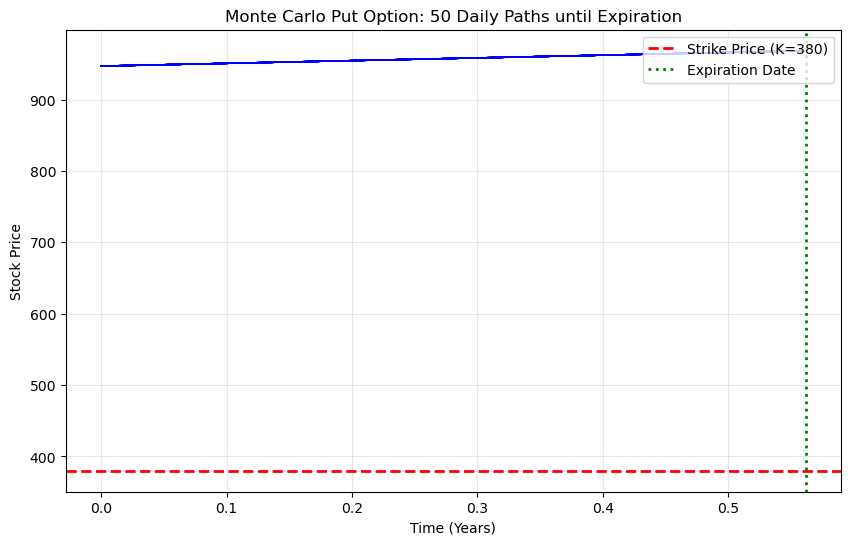

In [11]:
start_date = datetime(2025, 9, 24)
end_date = datetime(2026, 4, 17)
delta_days = (end_date - start_date).days
T = delta_days / 365

S0 = 946.94 # spot price (current stock price as of 2025-9-24)
K = 380 # strike price
sigma = 1E-10 # implied volatility
r = 0.04 # annual risk-free rate (Bank of England as of 2025-09-24)

vis_M = 50                 # Low number of paths (as requested)
vis_steps = delta_days     # One step per day until expiration
paths = simulate_paths(S0, T, r, sigma, vis_M, vis_steps)
visualize_paths(paths, vis_steps)

The second visualization is for the Put Option.

Here, we utilizes a realistic volatility of $\sigma = 0.25$, resulting in the characteristic "cone of uncertainty" where price paths diverge significantly over time. 

One important thing is, this plot explains the valuation result of $0.00$. The option is deeply Out-of-the-Money (OTM), that is, the initial spot price ($S_0 \approx 947$) is more than double the strike price ($K=380$). For the (put) option to have value, the stock price would need to crash below strike, represented by the red dashed line ($K=380$). As illustrated, even with significant volatility, none of the simulated paths decline steeply enough to reach the profit zone. Therefore, the terminal payoff $\max(K - S_T, 0)$ is zero for every path.

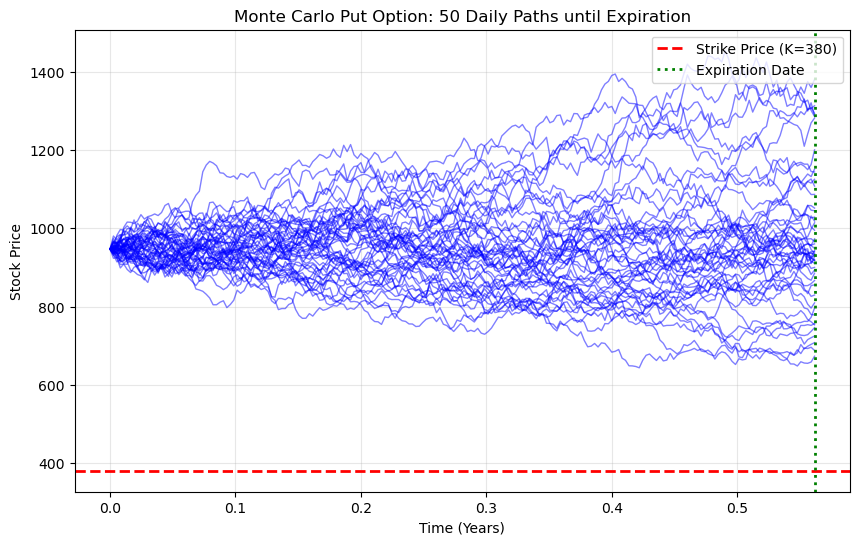

In [12]:
start_date = datetime(2025, 9, 24)
end_date = datetime(2026, 4, 17)
delta_days = (end_date - start_date).days
T = delta_days / 365

S0 = 946.94 # spot price (current stock price as of 2025-9-24)
K = 380 # strike price
sigma = 0.25 # implied volatility
r = 0.04 # annual risk-free rate (Bank of England as of 2025-09-24)

vis_M = 50                 # Low number of paths (as requested)
vis_steps = delta_days     # One step per day until expiration
paths = simulate_paths(S0, T, r, sigma, vis_M, vis_steps)
visualize_paths(paths, vis_steps)